In [1]:
import sys
import argparse
import yaml

import cv2
import torch
from torch.autograd import Variable

from models.yolov3 import *
from utils.utils import *
from utils.parse_yolo_weights import parse_yolo_weights
from utils.vis_bbox import vis_bbox

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Choose config file for this demo
cfg_path = './config/gaussian_yolov3_eval.cfg'

# Specify checkpoint file which contains the weight of the model you want to use
ckpt_path = './gaussian_yolov3_coco.pth'

# Path to the image file fo the demo
image_path = './data/gaussian_yolov3/traffic_1.jpg'

# Detection threshold
detect_thresh = 0.3

# Use CPU if gpu < 0 else use GPU
gpu = -1

In [3]:
# Load configratio parameters for this demo
with open(cfg_path, 'r') as f:
    cfg = yaml.load(f)

model_config = cfg['MODEL']
imgsize = cfg['TEST']['IMGSIZE']
confthre = cfg['TEST']['CONFTHRE'] 
nmsthre = cfg['TEST']['NMSTHRE']
gaussian = cfg['MODEL']['GAUSSIAN']

# if detect_thresh is not specified, the parameter defined in config file is used
if detect_thresh:
    confthre = detect_thresh

/Users/kimura/work/PyTorch_Gaussian_YOLOv3/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
# Load model
model = YOLOv3(model_config)

# Load weight from the checkpoint
print("loading checkpoint %s" % (ckpt_path))
state = torch.load(ckpt_path)

if 'model_state_dict' in state.keys():
    model.load_state_dict(state['model_state_dict'])
else:
    model.load_state_dict(state)

model.eval()

if gpu >= 0:
    # Send model to GPU
    model.cuda()

Gaussian YOLOv3
Gaussian YOLOv3
Gaussian YOLOv3
loading checkpoint ./gaussian_yolov3_coco.pth


In [5]:
# Load image
img = cv2.imread(image_path)

# Preprocess image
img_raw = img.copy()[:, :, ::-1].transpose((2, 0, 1))
img, info_img = preprocess(img, imgsize, jitter=0)  # info = (h, w, nh, nw, dx, dy)
img = np.transpose(img / 255., (2, 0, 1))
img = torch.from_numpy(img).float().unsqueeze(0)

if gpu >= 0:
    # Send model to GPU
    img = Variable(img.type(torch.cuda.FloatTensor))
else:
    img = Variable(img.type(torch.FloatTensor))

/Users/kimura/work/PyTorch_Gaussian_YOLOv3/venv/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


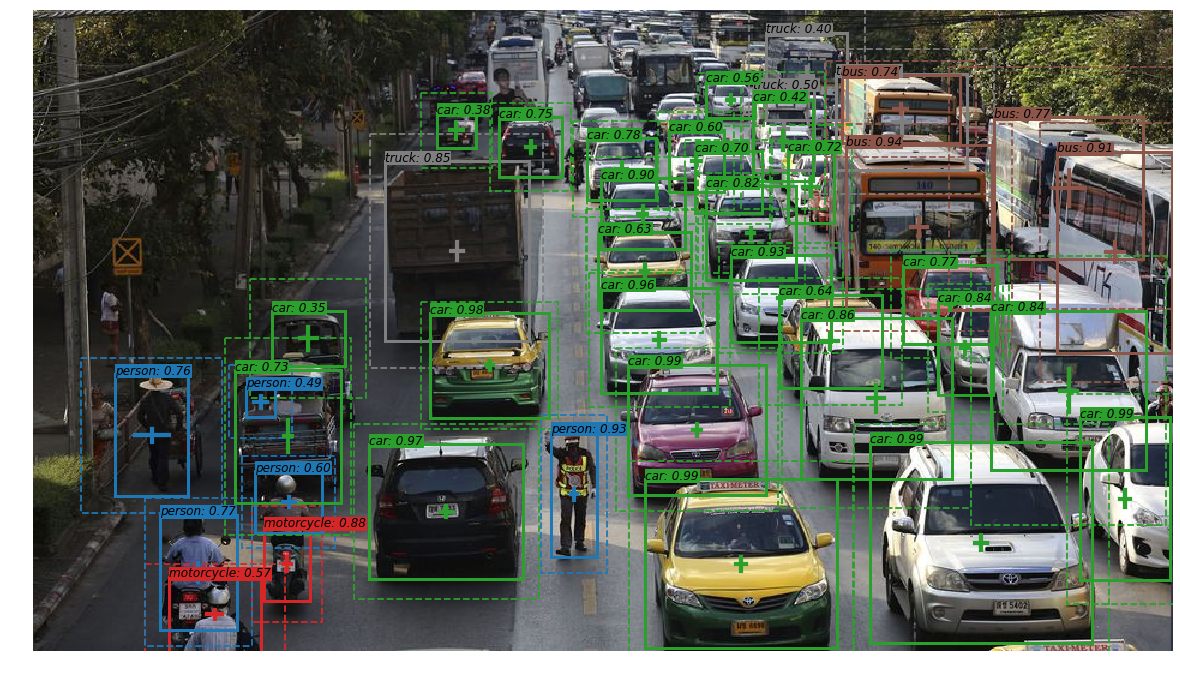

In [6]:
# Inference
with torch.no_grad():
    outputs = model(img)
    outputs = postprocess(outputs, 80, confthre, nmsthre)

if outputs[0] is None:
    print("No Objects Deteted!!")
    sys.exit(0)

# Visualize detected bboxes
coco_class_names, coco_class_ids, coco_class_colors = get_coco_label_names()

bboxes = list()
classes = list()
scores = list()
colors = list()
sigmas = list()

for output in outputs[0]:
    x1, y1, x2, y2, conf, cls_conf, cls_pred = output[:7]
    if gaussian:
        sigma_x, sigma_y, sigma_w, sigma_h = output[7:]
        sigmas.append([sigma_x, sigma_y, sigma_w, sigma_h])

    cls_id = coco_class_ids[int(cls_pred)]
    box = yolobox2label([y1, x1, y2, x2], info_img)
    bboxes.append(box)
    classes.append(cls_id)
    scores.append(cls_conf * conf)
    colors.append(coco_class_colors[int(cls_pred)])
    
    # image size scale used for sigma visualization
    h, w, nh, nw, _, _ = info_img
    sigma_scale_img = (w / nw, h / nh)
    
fig, ax = vis_bbox(
    img_raw, bboxes, label=classes, score=scores, label_names=coco_class_names, sigma=sigmas, 
    sigma_scale_img=sigma_scale_img,
    sigma_scale_xy=2., sigma_scale_wh=2.,  # 2-sigma
    show_inner_bound=False,  # do not show inner rectangle for simplicity
    instance_colors=colors, linewidth=3)

fig.savefig('demo.png')